<a href="https://colab.research.google.com/github/Svensone/kaggle-projects/blob/master/%5Bfastai%5D_Comp_Vision_Pneumonia_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

- 20.06.2020 moved to Colab since no GPU in Kaggle
- 23.06 ResNet34: accuracy= 97 (only pneumonia img)
- 23.06 adding covid data


In [ ]:
23

## Table of Content (Template)

Added by Me:
* Introduction
* Exec. Summary
First try fastai on Computer Vision Problem
    - simple version (only 1 dataset (chest-xray), resnet34)
    - advanced
        - add covid-chest xray data, 
        - small EDA, 
        - add callbacks/ data augmentation
* Table of Content

1. Setup
2. Data Loading and Preprocessing
    1. get data - 2 datasets (combine as pd.Dataframe - images in 1 folder ? Merge Databunch w datablock api ?)
    2. have a look
3. Data Preprocessing
    1. get labels, resize, normalize etc
    2. One-Hot-encoder / Augmentation
4. Build model 
    1. Model
    2. callbacks, train, fine-tune(unfreeze)
    3. test / predict
    4. Improve
5. Evaluation
    1. Visualization w. Grad-CAM
    2. ROC-AUC w. Plot
    3. Confusion-Matrix
6. Conclusion
    1. Findings
    2. Caveats
    3. possible Improvments  
    

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import necessary libaries

from fastai import *
from fastai.vision import *

# Data Exploration
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


#check versions

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
#print('fastai      :', fastai.__version__)

Python       : 3.6.9 (default, Apr 18 2020, 01:56:04) 
Numpy        : 1.18.5


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data Loading



In [4]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"svensone","key":"22bec247cc2d50ba95e8c868ae200972"}'}

In [5]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Jun 22 23:07 kaggle.json


In [6]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [7]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# List available datasets.
!kaggle datasets list 

In [9]:
!pwd

/content


In [8]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:38<00:00, 51.3MB/s]
100% 2.29G/2.29G [00:38<00:00, 64.5MB/s]


In [9]:
!unzip -q chest-xray-pneumonia.zip

In [14]:
!kaggle datasets list -s covid-19

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
imdevskp/corona-virus-report                                   COVID-19 Dataset                                     15MB  2020-06-21 06:54:52            251  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-19 00:27:19            820  
sudalairajkumar/covid19-in-india                               COVID-19 in India                                   224KB  2020-06-22 04:55:22             26  
roche-data-science-coalition/uncover                           UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53           3511  
kimjihoo/coronavirusdataset                   

In [33]:
# later merge with this
#!mkdir '/content/covid'

In [41]:
! kaggle datasets download bachrr/covid-chest-xray -p '/content/covid'

covid-chest-xray.zip: Skipping, found more recently modified local copy (use --force to force download)


In [42]:
!unzip -q /content/covid/covid-chest-xray.zip

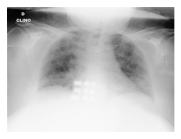

In [43]:
path_covid = Path('/content/covid')
img = open_image('/content/covid/images/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg')
img.show(figsize=(10,8))

In [46]:
df_covid = pd.read_csv('/content/covid/metadata.csv')


,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [52]:
df_covid.describe()
df_covid.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2',
       'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count',
       'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date',
       'location', 'folder', 'filename', 'doi', 'url', 'license',
       'clinical_notes', 'other_notes', 'Unnamed: 28'],
      dtype='object')

In [ ]:
# check GPU
!cat /proc/meminfo

In [ ]:
# data if in Kaggle

# path = Path('../input/chest-xray-pneumonia/chest_xray')
# path_train = path/'train'
# path_train.ls()

[PosixPath('../input/chest-xray-pneumonia/chest_xray/train/NORMAL'),
 PosixPath('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA')]

In [24]:
path = Path("/content/chest_xray/chest_xray")
path

PosixPath('/content/chest_xray/chest_xray')

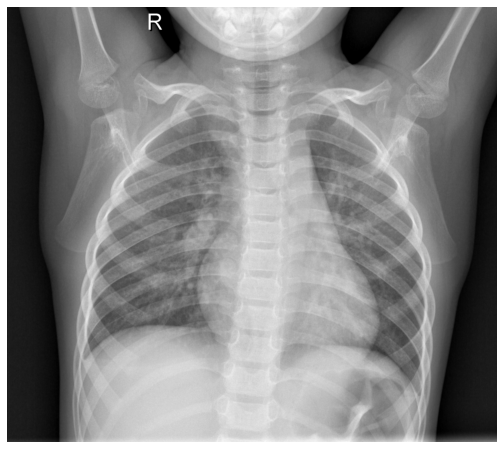

In [17]:
img = open_image("/content/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
img.show(figsize=(10,8))

In [18]:
path_train = Path('/content/chest_xray/chest_xray/train')
path_normal = path_train/"NORMAL"
path_pneumonia = path_train/"PNEUMONIA"

print(len(path_normal.ls()), len(path_pneumonia.ls()))


1342 3876


In [25]:
path_test = path/'test/NORMAL'
path_test_pne = path/'test/PNEUMONIA'
print(len(path_test.ls()), len(path_test_pne.ls()))

234 390


In [26]:
# create DataBunch with DataBlock Api (ImageDataBunch also possible but inflexible)
data_path = Path('/content/chest_xray/chest_xray')

# inspiration from https://www.kaggle.com/czou328018/pneumonia-detection-fastai

# basic parameters
data_size = 256
bs = 32
use_default_validation = False # in val dir only 8img each, super small validation set
# creating new valid set with 90/10 ration

# image transformations
tfms = get_transforms(do_flip=True, flip_vert=False, max_zoom=1.2)

if use_default_validation:
  data = (ImageList.from_folder(data_path, convert_mode = "L").split_by_folder().label_from_folder().transform(tfms, size = data_size).databunch(bs= bs).normalize(imagenet_stats))
else:
  data = (ImageList.from_folder(data_path/'train', convert_mode = 'L').split_by_rand_pct(0.1).label_from_folder().transform(tfms, size = data_size).databunch(bs = bs).normalize(imagenet_stats))

print(data)
# might need add_test_folder(test_folder= 'test)

ImageDataBunch;

Train: LabelList (4695 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/chest_xray/chest_xray/train;

Valid: LabelList (521 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: CategoryList
NORMAL,PNEUMONIA,PNEUMONIA,NORMAL,PNEUMONIA
Path: /content/chest_xray/chest_xray/train;

Test: None


In [ ]:
# # combining 2 Dataset
# Option 1. copy/paste folders together (3 folders(normal, pneum and covid))
# Option 2 with .add(ImageList) then only (normal/pneumonia as classes possible)
# src_combined = (ImageList.from_folder(path_data).add(ImageList.from_folder(path/'test-jpg-additional')))

In [27]:
print(data.classes, data.c)

['NORMAL', 'PNEUMONIA'] 2


In [28]:
len(data.train_ds), len(data.valid_ds)

(4695, 521)

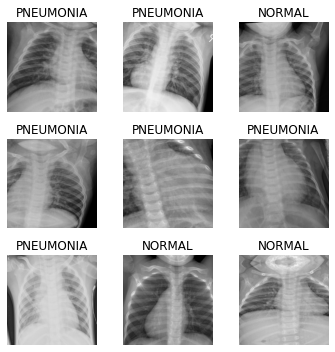

In [29]:
data.show_batch(3, figsize=(5,5))

## Model



In [ ]:
from fastai.utils.mem import *

In [ ]:
# check GPU

#watch -n1 nvidia-smi
#watch -n 0.2 nvidia-smi
# or 
#nvidia-smi --query-gpu=index,utilization.gpu --format=csv -l

#htop # check if CPU running efficient

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11128MB of GPU RAM free


In [30]:
learn = create_cnn(data, models.resnet34, metrics=accuracy )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 8.32E-03


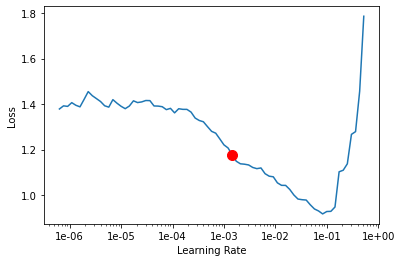

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [32]:
lr_base = 1e-3
print('Using base LR:', lr_base)
# Using CLR: lr_init = max_lr/div_factor, pct_start = % of iterations with increasing LR
learn.fit_one_cycle(5, div_factor = 25.0, pct_start = 0.3,
                    callbacks = callbacks.EarlyStoppingCallback(learn, monitor = 'valid_loss', min_delta = 0.01, patience = 3))

Using base LR: 0.001


epoch,train_loss,valid_loss,accuracy,time
0,0.401931,0.489541,0.879079,02:26
1,0.226958,0.224166,0.936660,02:24
2,0.185227,0.210286,0.930902,02:24
3,0.154853,0.172062,0.942418,02:23
4,0.144387,0.162224,0.944338,02:23


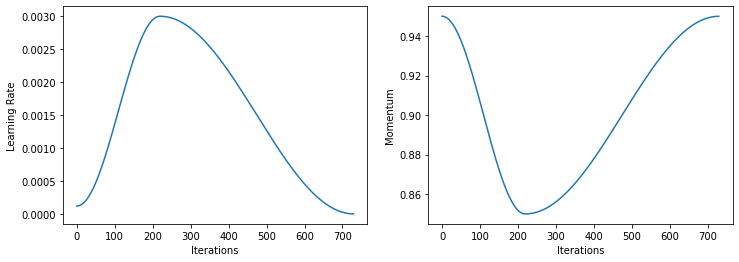

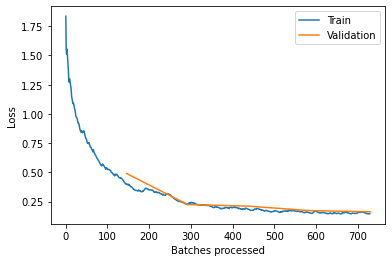

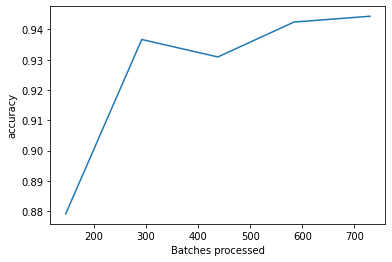

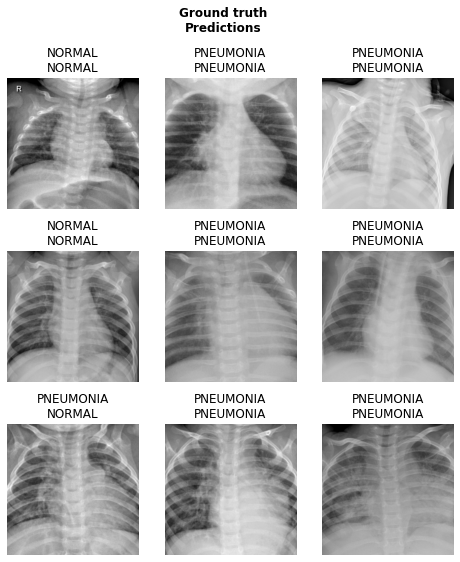

In [33]:
# Some visualizations of the process:
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()
learn.show_results(rows=3, figsize=(8,9))

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


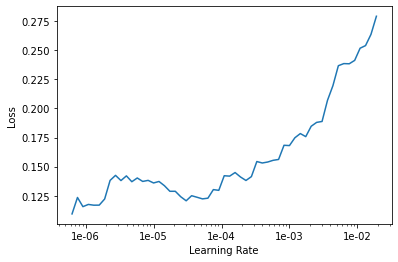

In [34]:
# fine-tuning model

# Save initial results, and unfreeze:
learn.save('stage_1')
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()


epoch,train_loss,valid_loss,accuracy,time
0,0.127177,0.124144,0.953935,02:30
1,0.110140,0.155559,0.946257,02:30
2,0.089555,0.121671,0.961612,02:30
3,0.075588,0.081651,0.971209,02:30


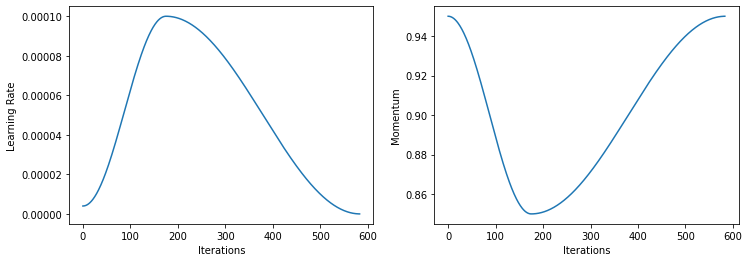

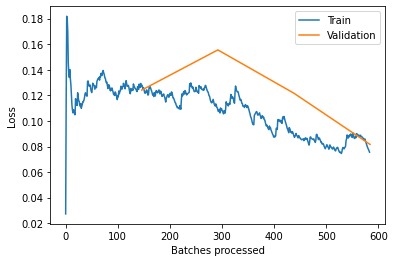

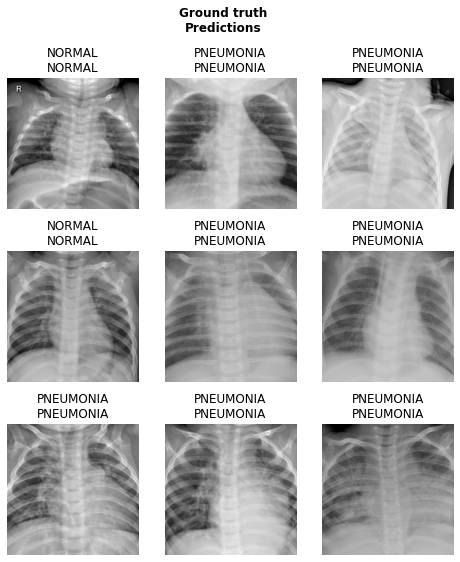

In [35]:
 # Re-fit entire model, using geometric (slice(a,b)) LR
lr_stage2 = slice(1e-5, lr_base/10)
learn.fit_one_cycle(4, lr_stage2)
# Visualize
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_losses()
#learn.recorder.plot_metrics()
learn.show_results(rows=3, figsize=(8,9))
# Save
learn.save('stage_2')

In [ ]:
## Prediction on Test set



In [ ]:
test = (ImageList.from_folder(data_path/'test'))
len(test)

624

In [ ]:
path_model = Path('/content/drive/My Drive/Colab Notebooks/fast.ai/lesson3/pneumonia/data/chest_xray')

learn = load_learner(path_model, test='test')

preds, _ = learn.get_preds(ds_type=DatasetType.Test)

TypeError: ignored